In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb
import optuna

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
census = pd.read_csv('./census_starter.csv')

In [3]:
train['cfips'].unique()

array([ 1001,  1003,  1005, ..., 56041, 56043, 56045], dtype=int64)

In [4]:
train[train['cfips']==1001]

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243
5,1001_2020-01-01,1001,Autauga County,Alabama,2020-01-01,2.969090,1242
6,1001_2020-02-01,1001,Autauga County,Alabama,2020-02-01,2.909326,1217
7,1001_2020-03-01,1001,Autauga County,Alabama,2020-03-01,2.933231,1227
8,1001_2020-04-01,1001,Autauga County,Alabama,2020-04-01,3.000167,1255
9,1001_2020-05-01,1001,Autauga County,Alabama,2020-05-01,3.004948,1257


In [5]:
pd.merge(train,census,how='inner',on='cfips')

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,pct_bb_2017,pct_bb_2018,pct_bb_2019,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,76.6,78.9,80.6,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,76.6,78.9,80.6,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,76.6,78.9,80.6,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,76.6,78.9,80.6,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,76.6,78.9,80.6,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122260,56045_2022-06-01,56045,Weston County,Wyoming,2022-06-01,1.803249,101,71.1,73.3,76.8,...,0.6,0.6,0.0,0.0,0.0,59605,52867.0,57031,53333.0,65566.0
122261,56045_2022-07-01,56045,Weston County,Wyoming,2022-07-01,1.803249,101,71.1,73.3,76.8,...,0.6,0.6,0.0,0.0,0.0,59605,52867.0,57031,53333.0,65566.0
122262,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100,71.1,73.3,76.8,...,0.6,0.6,0.0,0.0,0.0,59605,52867.0,57031,53333.0,65566.0
122263,56045_2022-09-01,56045,Weston County,Wyoming,2022-09-01,1.785395,100,71.1,73.3,76.8,...,0.6,0.6,0.0,0.0,0.0,59605,52867.0,57031,53333.0,65566.0


In [6]:
train['first_day_of_month'].unique()

array(['2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01',
       '2019-12-01', '2020-01-01', '2020-02-01', '2020-03-01',
       '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01',
       '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01',
       '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01',
       '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01',
       '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01',
       '2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01',
       '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01',
       '2022-08-01', '2022-09-01', '2022-10-01'], dtype=object)

In [7]:
census[census.isna().any(axis=1)]

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
92,80.5,79.1,80.4,NaN,NaN,2261,23.1,19.0,16.5,NaN,...,3.3,3.9,5.3,NaN,NaN,86019,82306.0,79867,NaN,NaN
1816,49.1,52.1,57.6,60.7,63.5,35039,12.0,12.5,12.6,10.6,...,0.8,NaN,0.8,0.4,0.7,33422,NaN,39952,42264.0,46994.0
2644,66.3,66.6,61.2,63.2,70.1,48243,18.4,16.0,10.8,14.3,...,0.0,0.0,0.0,0.0,0.0,46534,53194.0,53088,NaN,38659.0
2673,64.5,72.7,73.3,96.8,97.0,48301,4.7,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,80938,81875.0,83750,44076.0,NaN


In [8]:
census.columns

Index(['pct_bb_2017', 'pct_bb_2018', 'pct_bb_2019', 'pct_bb_2020',
       'pct_bb_2021', 'cfips', 'pct_college_2017', 'pct_college_2018',
       'pct_college_2019', 'pct_college_2020', 'pct_college_2021',
       'pct_foreign_born_2017', 'pct_foreign_born_2018',
       'pct_foreign_born_2019', 'pct_foreign_born_2020',
       'pct_foreign_born_2021', 'pct_it_workers_2017', 'pct_it_workers_2018',
       'pct_it_workers_2019', 'pct_it_workers_2020', 'pct_it_workers_2021',
       'median_hh_inc_2017', 'median_hh_inc_2018', 'median_hh_inc_2019',
       'median_hh_inc_2020', 'median_hh_inc_2021'],
      dtype='object')

In [9]:
from xgboost import XGBRegressor

C:\Users\user\anaconda3\envs\ml\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [10]:
xgb = XGBRegressor()
xgb.fit(pd.DataFrame(list(range(2017,2022))),census[census['cfips'] == 1001].loc[:,['pct_bb_2017','pct_bb_2018','pct_bb_2019','pct_bb_2020','pct_bb_2021']].transpose())

C:\Users\user\anaconda3\envs\ml\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [11]:
census[census['cfips'] == 1001].loc[:,['pct_bb_2017','pct_bb_2018','pct_bb_2019','pct_bb_2020','pct_bb_2021']].transpose().reset_index(drop=True)

,0
0,76.6
1,78.9
2,80.6
3,82.7
4,85.5


# census partition

In [12]:
tar1 = census[census['cfips'] == 1001].loc[:,['pct_bb_2017','pct_bb_2018','pct_bb_2019','pct_bb_2020','pct_bb_2021']].transpose().reset_index(drop=True)
tar2 = census[census['cfips'] == 1001].loc[:,['pct_college_2017','pct_college_2018','pct_college_2019','pct_college_2020','pct_college_2021']].transpose().reset_index(drop=True)
tar3 = census[census['cfips'] == 1001].loc[:,['pct_it_workers_2017','pct_it_workers_2018','pct_it_workers_2019','pct_it_workers_2020','pct_it_workers_2021']].transpose().reset_index(drop=True)
tar4 = census[census['cfips'] == 1001].loc[:,['median_hh_inc_2017','median_hh_inc_2018','median_hh_inc_2019','median_hh_inc_2020','median_hh_inc_2021']].transpose().reset_index(drop=True)
tar5 = census[census['cfips'] == 1001].loc[:,['pct_foreign_born_2017', 'pct_foreign_born_2018','pct_foreign_born_2019', 'pct_foreign_born_2020','pct_foreign_born_2021']].transpose().reset_index(drop=True)
target = pd.concat([tar1,tar2,tar3,tar4,tar5],axis=1)
target.columns = ['pct_bb','pct_college','pct_it_workers','median_hh_inc','pct_foreign_born']
target['year'] = list(range(2017,2022))
target

,pct_bb,pct_college,pct_it_workers,median_hh_inc,pct_foreign_born,year
0,76.6,14.5,1.3,55317.0,2.1,2017
1,78.9,15.9,1.1,58786.0,2.0,2018
2,80.6,16.1,0.7,58731.0,2.3,2019
3,82.7,16.7,0.6,57982.0,2.3,2020
4,85.5,16.4,1.1,62660.0,2.1,2021


In [68]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt

data = target

x = data['year']
y = data['pct_bb']

f1 = interpolate.interp1d(x,y)
f2 = interpolate.interp1d(x,y, kind='cubic')

x_new = np.linspace(2017,2023,12*6)

In [69]:
f1(x)

array([76.6 , 78.9 , 80.6 , 82.7 , 85.5 , 87.34, 89.5 ])

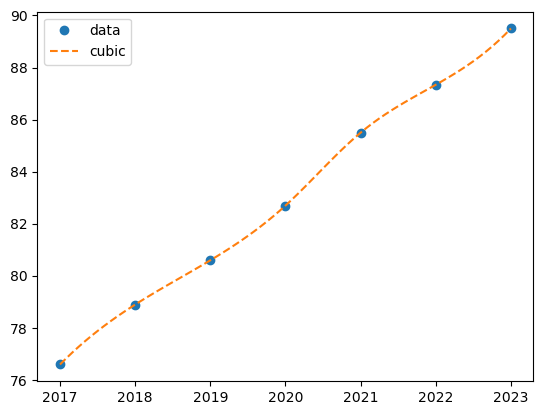

In [78]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt

data = target

x = data['year']
y = data['pct_bb']

# f1 = interpolate.interp1d(x,y)
f2 = interpolate.interp1d(x,y, kind='cubic')

x_new = np.linspace(2017,2023,12*6+1)
plt.plot(x,y,'o',x_new,f2(x_new),'--')
plt.legend(['data','cubic','spline'], loc='best')

plt.show()

In [79]:
x_new

array([2017.        , 2017.08333333, 2017.16666667, 2017.25      ,
       2017.33333333, 2017.41666667, 2017.5       , 2017.58333333,
       2017.66666667, 2017.75      , 2017.83333333, 2017.91666667,
       2018.        , 2018.08333333, 2018.16666667, 2018.25      ,
       2018.33333333, 2018.41666667, 2018.5       , 2018.58333333,
       2018.66666667, 2018.75      , 2018.83333333, 2018.91666667,
       2019.        , 2019.08333333, 2019.16666667, 2019.25      ,
       2019.33333333, 2019.41666667, 2019.5       , 2019.58333333,
       2019.66666667, 2019.75      , 2019.83333333, 2019.91666667,
       2020.        , 2020.08333333, 2020.16666667, 2020.25      ,
       2020.33333333, 2020.41666667, 2020.5       , 2020.58333333,
       2020.66666667, 2020.75      , 2020.83333333, 2020.91666667,
       2021.        , 2021.08333333, 2021.16666667, 2021.25      ,
       2021.33333333, 2021.41666667, 2021.5       , 2021.58333333,
       2021.66666667, 2021.75      , 2021.83333333, 2021.91666

# regressor 

In [21]:
from sklearn.linear_model import LinearRegression
import numpy as np

tp = []
for col in target.columns:
    linear = LinearRegression()
    linear.fit(np.array(target['year']).reshape(-1, 1),np.array(target[col]).reshape(-1, 1))
    tp.append(linear.predict([[2022]]))

target = target.append(pd.DataFrame([[float(i.squeeze()) for i in tp]],columns=target.columns))
target = target.reset_index(drop=True)

tp = []    
for col in target.columns:
    linear = LinearRegression()
    linear.fit(np.array(target['year']).reshape(-1, 1),np.array(target[col]).reshape(-1, 1))
    tp.append(linear.predict([[2023]]))

target = target.append(pd.DataFrame([[float(i.squeeze()) for i in tp]],columns=target.columns))
target = target.reset_index(drop=True)


C:\Users\user\AppData\Local\Temp\ipykernel_29680\3658524884.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target = target.append(pd.DataFrame([[float(i.squeeze()) for i in tp]],columns=target.columns))
C:\Users\user\AppData\Local\Temp\ipykernel_29680\3658524884.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  target = target.append(pd.DataFrame([[float(i.squeeze()) for i in tp]],columns=target.columns))


In [22]:
target

,pct_bb,pct_college,pct_it_workers,median_hh_inc,pct_foreign_born,year
0,76.60,14.50,1.30,55317.0,2.10,2017.0
1,78.90,15.90,1.10,58786.0,2.00,2018.0
2,80.60,16.10,0.70,58731.0,2.30,2019.0
3,82.70,16.70,0.60,57982.0,2.30,2020.0
4,85.50,16.40,1.10,62660.0,2.10,2021.0
5,87.34,17.30,0.69,62859.8,2.25,2022.0
6,89.50,17.76,0.60,64248.0,2.28,2023.0


In [23]:
target['pct_bb']

0    76.60
1    78.90
2    80.60
3    82.70
4    85.50
5    87.34
6    89.50
Name: pct_bb, dtype: float64

# RNN

In [ ]:
def rnn_data(data,label_name,date_range=1):
    data = data.reset_index(drop=True)
    y_train = []
    for i in range(date_range-1,len(data)):
        y_train.append(data.loc[i,label_name])
    data = data.drop(label_name,axis=1)
    x_train = []
    for i in range(date_range-1,len(data)):
        x_train.append(np.array(data.loc[i-(date_range-1):i,:]))
    return np.array(x_train), np.array(y_train)

In [ ]:
target

In [ ]:
x_train,y_train = rnn_data(target,'pct_bb',date_range=2)

In [ ]:
x_train

In [ ]:
from tensorflow import keras
``

In [ ]:
train[train['cfips'] == 1001]['microbusiness_density'].plot()

In [ ]:
train[train['cfips'] == 1001][''].plot()

In [ ]:
state_dict = train[['cfips', 'state', 'county']]
state_dict = state_dict.set_index('cfips')
state_dict = state_dict.drop_duplicates()
state_dict = state_dict.to_dict()

test['state'] = test['cfips'].map(state_dict['state'])
test['county'] = test['cfips'].map(state_dict['county'])

In [ ]:
test